In [1]:
import imgaug

In [2]:
import sys
sys.path.append('..')
from modules.training_helpers import *
from modules.configfile import config
import logging
import random as random
import optparse
import cPickle as pickle
import h5py
import numpy as np
random.seed(config['seed'])

/home/anmol/.virtualenvs/brats/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO:training_helpers.py:Current std_scale = 6
INFO:training_helpers.py:[Training] Generating patches from Patient ID = 55, num = 0


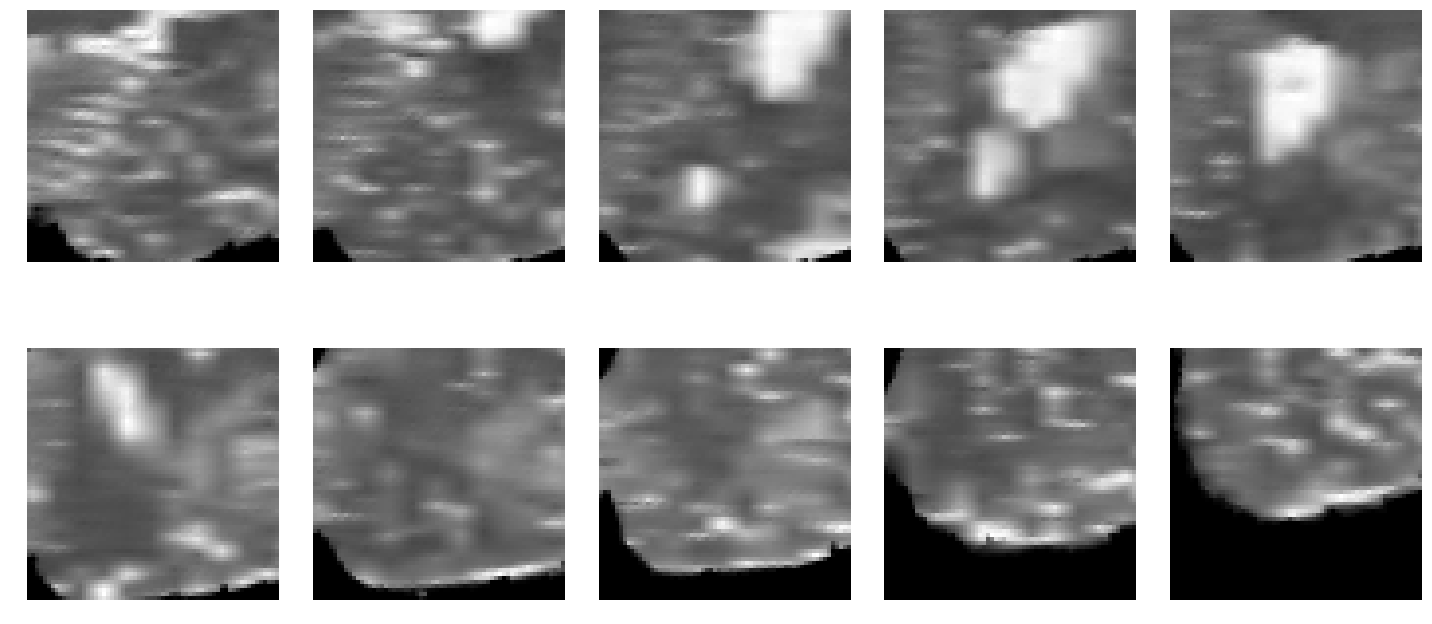

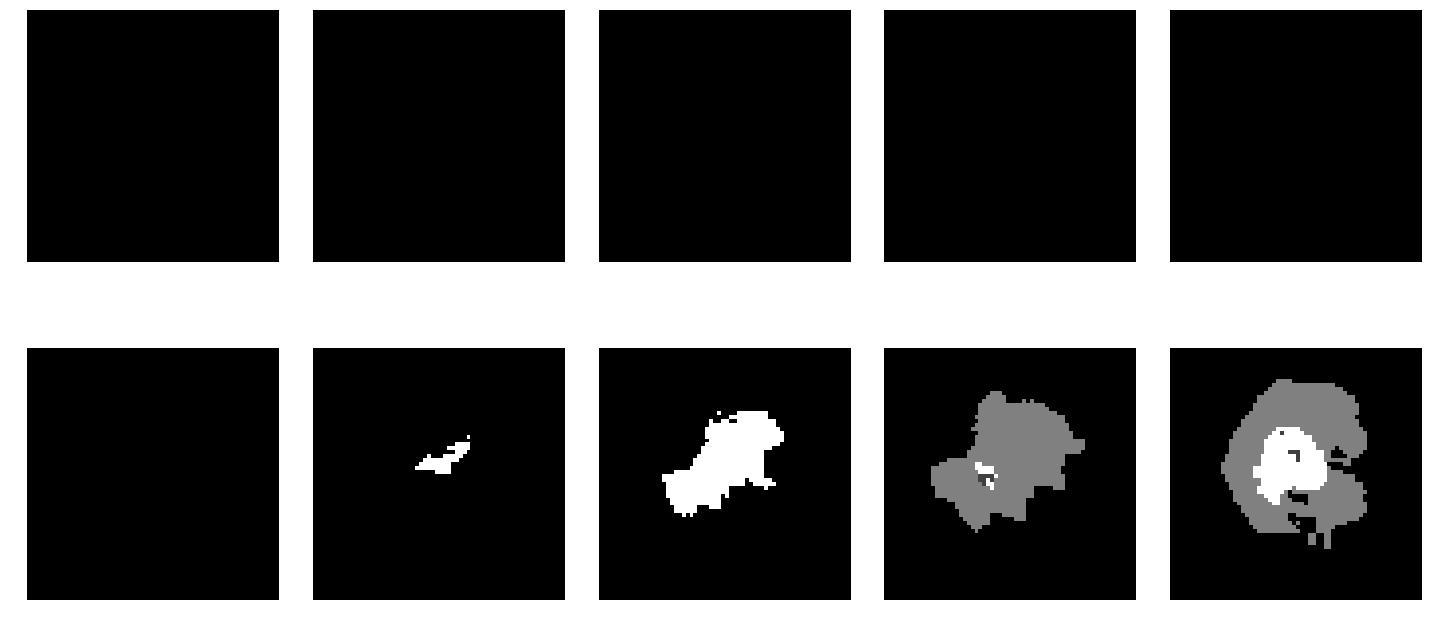

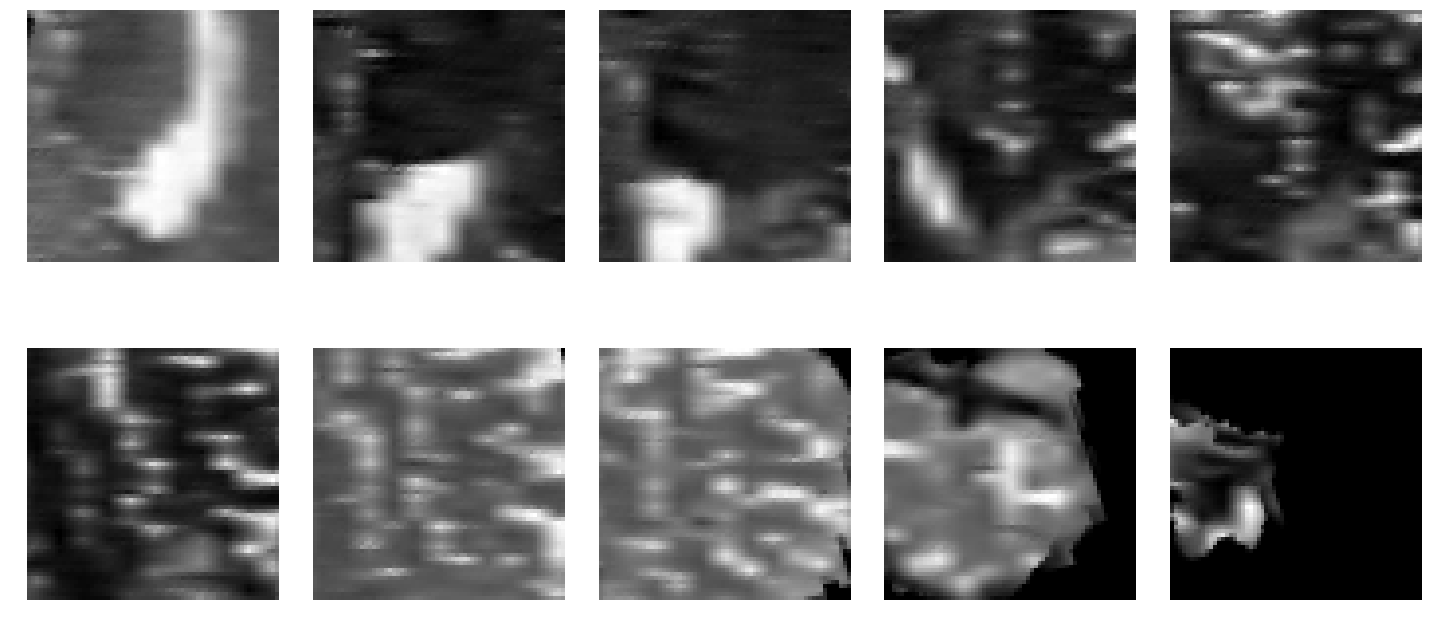

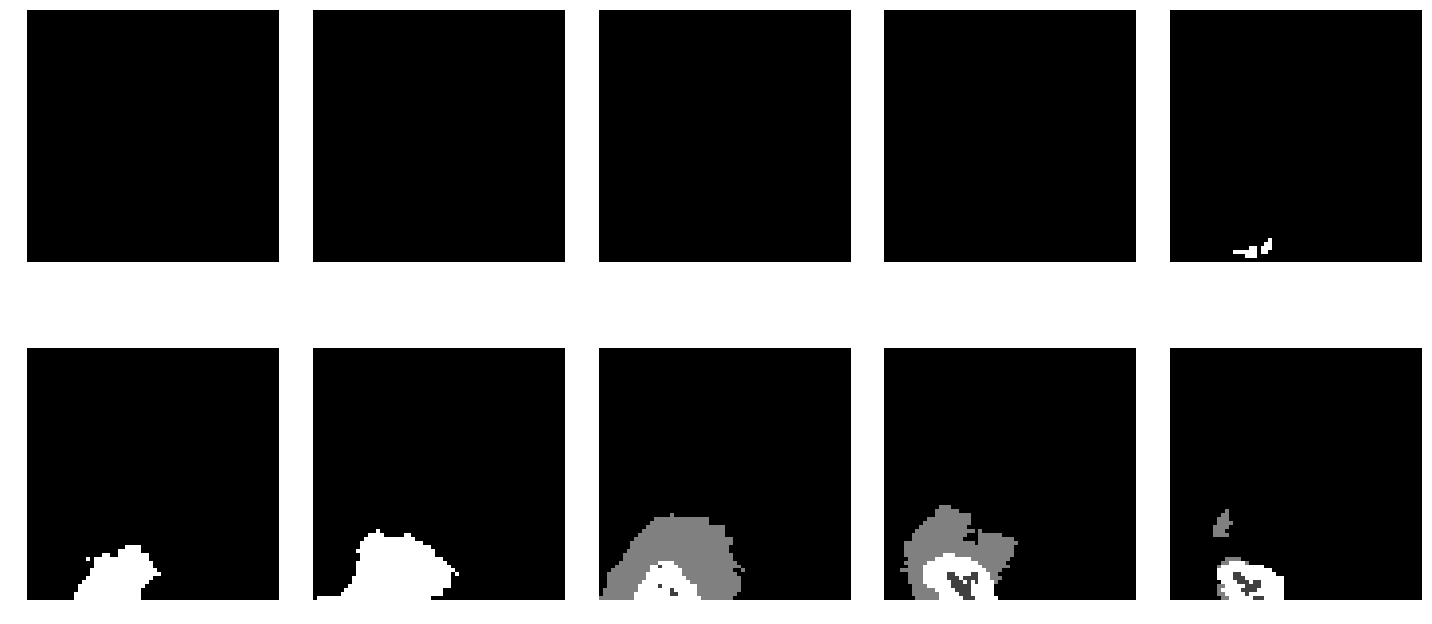

((2, 4, 64, 64, 64), (2, 3, 64, 64, 64))


In [6]:
mean_var = pickle.load(open(config['saveMeanVarCombinedData'], 'rb'))

# open new database with cropped images

if config['gen_patches_from'] == 'cropped':
    hdf5_file = h5py.File(config['hdf5_filepath_cropped'], mode='r')
    hdf5_file_g = hdf5_file['preprocessed']
else:
    hdf5_file = h5py.File(config['hdf5_filepath_prefix'], mode='r')
    hdf5_file_g = hdf5_file['original_data']

# get all the HGG/LGG data
training_data = hdf5_file_g['training_data_hgg']
training_data_segmasks = hdf5_file_g['training_data_segmasks_hgg']

# ======================================================================================

# --------------------------------------------------------------------------------------
# split data into training and testing
# --------------------------------------------------------------------------------------
indices = list(range(0, training_data.shape[0]))
random.shuffle(indices) # in-place shuffling

train_end = int((len(indices) * config['data_split']['train']) / 100.0)
train_indices = indices[0:train_end]
test_indices = indices[train_end:]

# ======================================================================================
batch_size = 10
augment = ['permute', 'remove_seq', 'add_noise']
train_gen = generate_patch_batches(X=training_data, Y=training_data_segmasks,
                                   t_i=train_indices, mean_var=mean_var, batch_size=batch_size, debug_mode=True,
                                   applyNorm=False, augment=augment)

test_gen = generate_patch_batches(X=training_data, Y=training_data_segmasks,
                                  t_i=test_indices, mean_var=mean_var, batch_size=batch_size, debug_mode=True,
                                  applyNorm=False, augment=augment)

count = 0
for x_patches, y_patches in test_gen:
    print(x_patches.shape, y_patches.shape)
    break

In [7]:
x_patches.shape

(2, 4, 64, 64, 64)

In [8]:
y_patches.shape

(2, 3, 64, 64, 64)

In [24]:
from imgaug import augmenters as iaa
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

# random example images
images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.
seq = iaa.Sequential(
    [
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
#             shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
)])

In [25]:
images_aug = seq.augment_images(x_patches[0,0,])

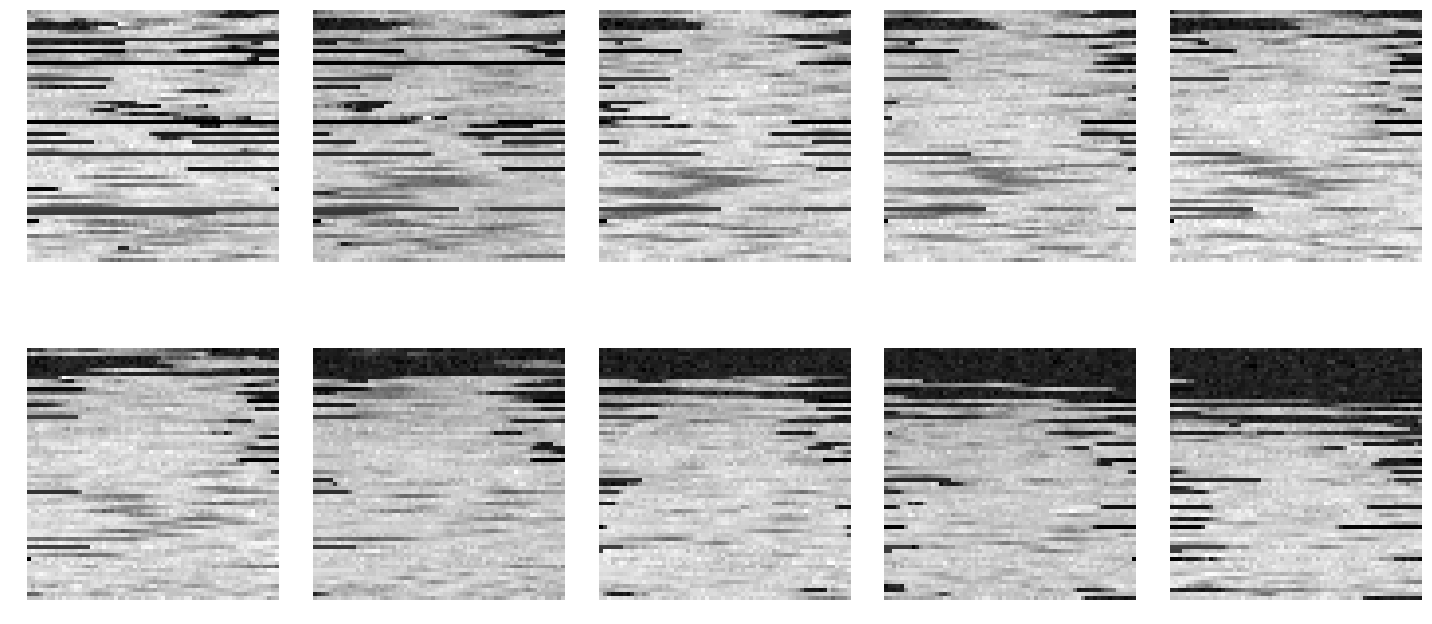

In [28]:
viewArbitraryVolume(images_aug, slice_idx=1, modality=1)